In [1]:
#import libs

#keras
import keras as K

#sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#visualization
import matplotlib.pyplot as plt


#data processing
import numpy as np
import pandas as pd
from pytorchtools import EarlyStopping

#system
import gc

Using TensorFlow backend.


In [2]:
#load the data

#signals
X_VEB = pd.read_csv('input/data_VEB_v2.csv',header=None, index_col=None)
X_VEB = X_VEB.T

X_SVEB = pd.read_csv('input/data_SVEB_v2.csv',header=None, index_col=None)
X_SVEB = X_SVEB.T

#labels
y_VEB = pd.read_csv('input/labels_VEB_v2.csv',header=None, index_col=None)
y_SVEB = pd.read_csv('input/labels_SVEB_v2.csv',header=None, index_col=None)

#meta-features
meta_VEB = pd.read_csv('input/meta_features_VEB_v2.csv',header=None, index_col=None)
meta_SVEB = pd.read_csv('input/meta_features_SVEB_v2.csv',header=None, index_col=None)

#get numpy matrixes
X_VEB = X_VEB.values
y_VEB = y_VEB.values
meta_VEB = meta_VEB.values

X_SVEB = X_SVEB.values
y_SVEB = y_SVEB.values
meta_SVEB = meta_SVEB.values


#merge datasets togather
X = np.concatenate((X_VEB,X_SVEB))
y = np.concatenate((y_VEB,y_SVEB))
meta = np.concatenate((meta_VEB.T,meta_SVEB.T))

del X_VEB,X_SVEB,y_VEB,y_SVEB,meta_VEB,meta_SVEB
gc.collect()

0

In [3]:
def upsampling(X_loc,y_loc,meta_loc):
    
    UniqClass = np.unique(y_loc)
    
    mostQreq = 0
    numSam_max = 0

    for i in UniqClass:
        numSam = np.where(y_loc == i)[0].shape[0]
        if numSam_max < numSam:
            numSam_max = numSam
            mostQreq = i


    for i in UniqClass:
        if i == mostQreq:
            continue
        else:
            #applying of upsampling trainng set
            X_US = np.zeros((numSam_max - np.where(y_loc == i)[0].shape[0],X_loc.shape[1]))
            X_minor = X_loc[np.where(y_loc == i)[0]]
            y_minor = np.zeros((X_US.shape[0])) + i
            meta_loc_US = np.zeros((numSam_max - np.where(y_loc == i)[0].shape[0],meta_loc.shape[1]))

            for j in range(X_US.shape[0]):
                ind = np.random.randint(0,X_minor.shape[0])
                X_US[j,:] = X_minor[ind,:]
                meta_loc_US[j,:] = meta_loc[ind,:]

            X_loc = np.concatenate((X_loc,X_US))
            y_loc = np.concatenate((y_loc,y_minor))
            meta_loc = np.concatenate((meta_loc,meta_loc_US))

    # need to add meta features
    #need to add random permutation
    temp = np.zeros((X_loc.shape[0],X_loc.shape[1]+meta_loc.shape[1]+1))
    temp[:,0:64] = X_loc
    temp[:,64:64+9] = meta_loc
    temp[:,64+9] = y_loc

    temp = np.take(temp,np.random.permutation(temp.shape[0]),axis=0,out=temp)

    X_loc = temp[:,0:64]
    meta_loc = temp[:,64:64+9] 
    y_loc = temp[:,64+9]
    
    return X_loc,y_loc,meta_loc

In [4]:
enc = LabelEncoder()
y = enc.fit_transform(y)

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
#custom metric for optimization
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [6]:
#import keras 
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

#define architecture for EEG recognizer
def ECG_rec(input_size,output_size):
    inputs = Input(input_size)
    conv1_1 = Conv1D(64, 4, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)
    flat_1 = Flatten()(pool1_1)
    dense1_1 = Dense(10,activation='relu')(flat_1)
    dense1_1 = Dropout(0.5)(dense1_1)
    final_1 = Dense(output_size,activation='softmax')(dense1_1)
                         
    conv1_2 = Conv1D(64, 8, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
    flat_2 = Flatten()(pool1_2)
    dense1_2 = Dense(10,activation='relu')(flat_2)
    dense1_2 = Dropout(0.5)(dense1_2)
    final_2 = Dense(output_size,activation='softmax')(dense1_2)
    
    conv1_3 = Conv1D(64, 16, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    pool1_3 = MaxPooling1D(pool_size=2)(conv1_3)
    flat_3 = Flatten()(pool1_3)
    dense1_3 = Dense(10,activation='relu')(flat_3)
    dense1_3 = Dropout(0.5)(dense1_3)
    final_3 = Dense(output_size,activation='softmax')(dense1_3)
    
    final = Average()([final_1,final_2,final_3])
    model = Model(input = inputs, output = final)
                           
    #model.summary()

    return model

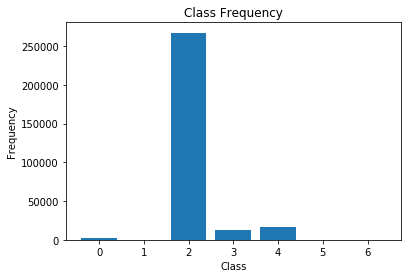

In [7]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
K.clear_session()

enc = OneHotEncoder(handle_unknown='ignore')

#selection of number of seeds for snapshot ensemblinging
num_seed = 3

#selection of number of folds for learning
n_folds = 3


skf = StratifiedKFold(n_splits=n_folds)
#kfold cross-validation
kf = KFold(n_folds,shuffle=True,random_state= 1)

for seed in range(1,num_seed+1):
    
    np.random.seed(seed)
    
    output_size=(7) #input shape of the data
    input_size=(64,1) #output shape of the data
    
    kf = KFold(n_folds,shuffle=True,random_state= 1) #cross-validation
    
    for _fold, (train_index, val_index) in enumerate(kf.split(X)):
        
        print("\n")
        print("FOLD {}".format(_fold))
        print("SEED {}".format(seed))
        print("\n")
        
        lr=0.1e-2 #learning rate
        epochs = 100 # n_epochs
        batch_size = 128 #n batches
        patience = 10 #early stopping
        min_delta=0.01 #early stopping
        
        #divide data by train and validation sets
        x_train = X[train_index,:]
        x_val = X[val_index,:]
        
        y_train = y[train_index]
        y_val = y[val_index]
        
        meta_train = meta[train_index,:]
        meta_val = meta[val_index,:]
        
        x_train,y_train,meta_train = upsampling(x_train,y_train,meta_train)
        x_val,y_val,meta_val = upsampling(x_val,y_val,meta_val)
        
        
        
        x_train = x_train.reshape(x_train.shape[0],64,1)
        x_val = x_val.reshape(x_val.shape[0],64,1)
        
        y_val = y_val.reshape(y_val.shape[0],1)
        y_train = y_train.reshape(y_train.shape[0],1)
        
        y_val = enc.fit_transform(y_val).toarray()
        y_train = enc.fit_transform(y_train).toarray()
        
        
        
        
        
        #load the model
        model = ECG_rec(input_size,output_size)
        model.compile(optimizer = Adam(lr), loss = 'categorical_crossentropy', metrics = [auc_roc])
        
        #early stopping
        earlystopper = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min',min_delta=min_delta)
        checkpointer = ModelCheckpoint('model-ECG_VEB-seed{}-fold{}.h5'.format(seed,_fold), monitor='val_loss', mode='min',verbose=1, save_best_only=True)
        #train model
        results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                            callbacks=[earlystopper, checkpointer],
                           validation_data = (x_val, y_val))
        
        #clear model in order to avoid collision
        K.clear_session()
        del model
        gc.collect()



FOLD 0
SEED 1


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 1247071 samples, validate on 623980 samples
Epoch 1/100
1247071/1247071 [==============================] - 231s 185us/step - loss: 0.7764 - auc_roc: 0.9427 - val_loss: 0.5120 - val_auc_roc: 0.9626

Epoch 00001: val_loss improved from inf to 0.51201, saving model to model-ECG_VEB-seed1-fold0.h5
Epoch 2/100
1247071/1247071 [==============================] - 237s 190us/step - loss: 0.6379 - auc_roc: 0.9665 - val_loss: 0.4777 - val_auc_roc: 0

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Train on 1247540 samples, validate on 623511 samples
Epoch 1/100
1247540/1247540 [==============================] - 237s 190us/step - loss: 0.7066 - auc_roc: 0.9490 - val_loss: 0.5213 - val_auc_roc: 0.9681

Epoch 00001: val_loss improved from inf to 0.52127, saving model to model-ECG_VEB-seed1-fold1.h5
Epoch 2/100
1247540/1247540 [==============================] - 236s 189us/step - loss: 0.5525 - auc_roc: 0.9715 - val_loss: 0.5710 - val_auc_roc: 0.9730

Epoch 00002: val_loss did not improve from 0.52127
Epoch 3/100
1247540/1247540 [==============================] - 235s 189us/step - loss: 0.5011 - auc_roc: 0.9741 - val_loss: 0.5178 - val_auc_roc: 0.9755

Epoch 00003: val_loss improved from 0.52127 to 0.51782, saving model to model-ECG_VEB-seed1-fold1.h5
Epoch 4/100
1247540/1247540 [==============================] - 227s 182us/step - loss: 0.4736 - auc_roc: 0.9764 - val_loss: 0.5417 - val_auc_roc: 0.9772

Epoch 00004: val_loss did not improve from 0.51782
Epoch 5/100
1247540/1247540 [==

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Train on 1247491 samples, validate on 623560 samples
Epoch 1/100
1247491/1247491 [==============================] - 227s 182us/step - loss: 0.8314 - auc_roc: 0.9349 - val_loss: 0.4278 - val_auc_roc: 0.9607

Epoch 00001: val_loss improved from inf to 0.42782, saving model to model-ECG_VEB-seed1-fold2.h5
Epoch 2/100
1247491/1247491 [==============================] - 226s 181us/step - loss: 0.6822 - auc_roc: 0.9663 - val_loss: 0.4269 - val_auc_roc: 0.9686

Epoch 00002: val_loss improved from 0.42782 to 0.42694, saving model to model-ECG_VEB-seed1-fold2.h5
Epoch 3/100
1247491/1247491 [==============================] - 227s 182us/step - loss: 0.6395 - auc_roc: 0.9702 - val_loss: 0.4089 - val_auc_roc: 0.9714

Epoch 00003: val_loss improved from 0.42694 to 0.40893, saving model to model-ECG_VEB-seed1-fold2.h5
Epoch 4/100
1247491/1247491 [==============================] - 234s 188us/step - loss: 0.6148 - auc_roc: 0.9724 - val_loss: 0.3899 - val_auc_roc: 0.9732

Epoch 00004: val_loss improved f

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Train on 1247071 samples, validate on 623980 samples
Epoch 1/100
1247071/1247071 [==============================] - 250s 201us/step - loss: 0.7333 - auc_roc: 0.9478 - val_loss: 0.6237 - val_auc_roc: 0.9657

Epoch 00001: val_loss improved from inf to 0.62369, saving model to model-ECG_VEB-seed2-fold0.h5
Epoch 2/100
1247071/1247071 [==============================] - 241s 193us/step - loss: 0.5828 - auc_roc: 0.9691 - val_loss: 0.5932 - val_auc_roc: 0.9712

Epoch 00002: val_loss improved from 0.62369 to 0.59319, saving model to model-ECG_VEB-seed2-fold0.h5
Epoch 3/100
1247071/1247071 [==============================] - 246s 198us/step - loss: 0.5399 - auc_roc: 0.9726 - val_loss: 0.5877 - val_auc_roc: 0.9736

Epoch 00003: val_loss improved from 0.59319 to 0.58774, saving model to model-ECG_VEB-seed2-fold0.h5
Epoch 4/100
1247071/1247071 [==============================] - 232s 186us/step - loss: 0.5141 - auc_roc: 0.9744 - val_loss: 0.6074 - val_auc_roc: 0.9750

Epoch 00004: val_loss did not im

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Train on 1247540 samples, validate on 623511 samples
Epoch 1/100
1247540/1247540 [==============================] - 232s 186us/step - loss: 0.7268 - auc_roc: 0.9473 - val_loss: 0.5453 - val_auc_roc: 0.9661

Epoch 00001: val_loss improved from inf to 0.54534, saving model to model-ECG_VEB-seed2-fold1.h5
Epoch 2/100
1247540/1247540 [==============================] - 231s 185us/step - loss: 0.5701 - auc_roc: 0.9697 - val_loss: 0.5957 - val_auc_roc: 0.9719

Epoch 00002: val_loss did not improve from 0.54534
Epoch 3/100
1247540/1247540 [==============================] - 233s 187us/step - loss: 0.5235 - auc_roc: 0.9734 - val_loss: 0.5963 - val_auc_roc: 0.9746

Epoch 00003: val_loss did not improve from 0.54534
Epoch 4/100
1247540/1247540 [==============================] - 239s 192us/step - loss: 0.4962 - auc_roc: 0.9756 - val_loss: 0.6135 - val_auc_roc: 0.9763

Epoch 00004: val_loss did not improve from 0.54534
Epoch 5/100
1247540/1247540 [==============================] - 239s 192us/step - 

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Train on 1247491 samples, validate on 623560 samples
Epoch 1/100
1247491/1247491 [==============================] - 251s 201us/step - loss: 0.8017 - auc_roc: 0.9361 - val_loss: 0.4240 - val_auc_roc: 0.9629

Epoch 00001: val_loss improved from inf to 0.42399, saving model to model-ECG_VEB-seed2-fold2.h5
Epoch 2/100
1247491/1247491 [==============================] - 241s 193us/step - loss: 0.6315 - auc_roc: 0.9686 - val_loss: 0.4139 - val_auc_roc: 0.9712

Epoch 00002: val_loss improved from 0.42399 to 0.41393, saving model to model-ECG_VEB-seed2-fold2.h5
Epoch 3/100
1247491/1247491 [==============================] - 251s 201us/step - loss: 0.5800 - auc_roc: 0.9731 - val_loss: 0.3666 - val_auc_roc: 0.9745

Epoch 00003: val_loss improved from 0.41393 to 0.36656, saving model to model-ECG_VEB-seed2-fold2.h5
Epoch 4/100
1247491/1247491 [==============================] - 238s 191us/step - loss: 0.5540 - auc_roc: 0.9757 - val_loss: 0.4037 - val_auc_roc: 0.9764

Epoch 00004: val_loss did not im

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Train on 1247071 samples, validate on 623980 samples
Epoch 1/100
1247071/1247071 [==============================] - 234s 188us/step - loss: 0.7245 - auc_roc: 0.9495 - val_loss: 0.5021 - val_auc_roc: 0.9665

Epoch 00001: val_loss improved from inf to 0.50215, saving model to model-ECG_VEB-seed3-fold0.h5
Epoch 2/100
1247071/1247071 [==============================] - 235s 188us/step - loss: 0.5967 - auc_roc: 0.9696 - val_loss: 0.5047 - val_auc_roc: 0.9716

Epoch 00002: val_loss did not improve from 0.50215
Epoch 3/100
1247071/1247071 [==============================] - 235s 188us/step - loss: 0.5511 - auc_roc: 0.9731 - val_loss: 0.4695 - val_auc_roc: 0.9744

Epoch 00003: val_loss improved from 0.50215 to 0.46945, saving model to model-ECG_VEB-seed3-fold0.h5
Epoch 4/100
1247071/1247071 [==============================] - 236s 189us/step - loss: 0.5268 - auc_roc: 0.9754 - val_loss: 0.5116 - val_auc_roc: 0.9760

Epoch 00004: val_loss did not improve from 0.46945
Epoch 5/100
1247071/1247071 [==

C:\Users\Victor\AppData\Local\conda\conda\envs\ptorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`


Train on 1247540 samples, validate on 623511 samples
Epoch 1/100
1102080/1247540 [=========================>....] - ETA: 23s - loss: 0.7767 - auc_roc: 0.9404